In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# Add the directory containing diffusive_nested_sampling to sys.path
sys.path.append(os.path.abspath( "../.."))
import spike_and_slab

In [3]:
def log_likelihood(x):
    '''
    20-D spike and slab likelihood function

    @param x : coordinate
    @return L : likelihood
    '''
    u = 0.01
    v = 0.1

    # Spike
    t1 = np.sum(-0.5 * (x / v) ** 2) - x.size * np.log(v * np.sqrt(2 * np.pi))
    
    # Slab
    t2 = np.sum(-0.5 * ((x - 0.031) / u) ** 2) - x.size * np.log(u * np.sqrt(2 * np.pi)) + np.log(100.0)

    logL = np.logaddexp(t1, t2)
    return logL

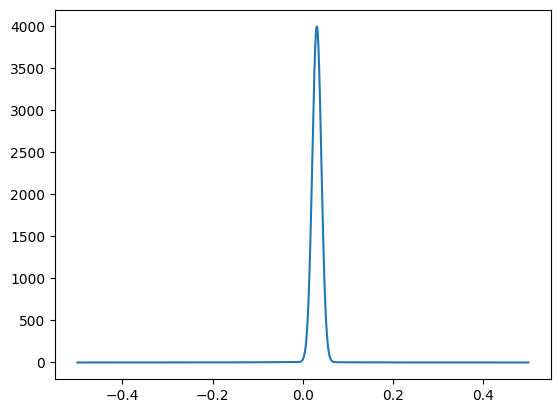

In [4]:
x = np.linspace(-0.5, 0.5, 10000)
y = np.exp([log_likelihood(x_i) for x_i in x])
plt.plot(x, y)
# plt.plot(x, y_spike)
# plt.plot(x, y_slab)
plt.show()

In [5]:
chain, levels, particle = spike_and_slab.main()

/home/tom-egg/Research/nested_sampling/diffusive_nested_sampling/levels.py:24: RuntimeWarning: divide by zero encountered in log
  self.levels = [Level(0, np.log(0.0), prev=None)]    # levels are initialized with index, logL, and a previous logX if exists
100%|██████████| 800/800 [23:22<00:00,  1.75s/it]


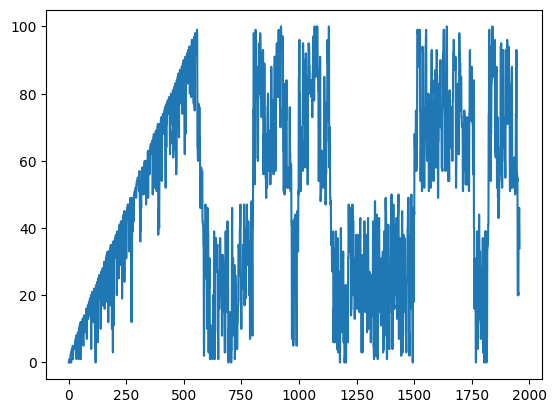

In [6]:
y = particle[0].history['j']
x = range(len(y))
plt.plot(x, y)
plt.show()

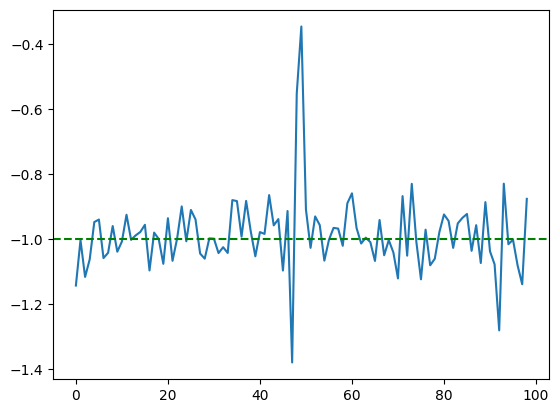

-0.9872487250105361


In [7]:
list_levels = [levels.get_level(i) for i in range(levels.current_max_J)]
Xs = np.array([level.get_log_X for level in list_levels])
y = Xs[1:] - Xs[:-1]
x = range(len(y))
plt.plot(x, y)
plt.axhline(y=-1.0,linestyle='--', color='green')
plt.show()
print(np.mean(y))

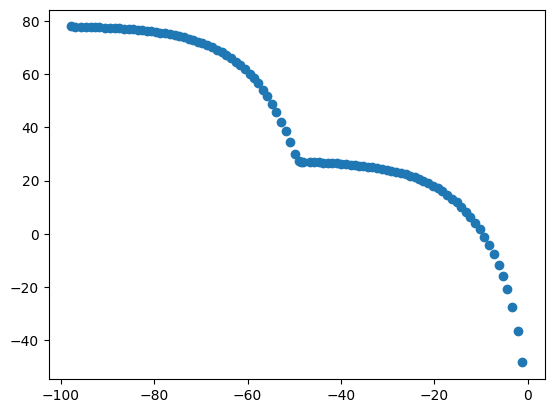

In [8]:
logL = [level.log_likelihood_bound for level in list_levels]
logX = [level.get_log_X for level in list_levels]
plt.scatter(logX, logL)

In [107]:
# Compute logZ
log_Ls = np.sort(chain['L'])
logL_bins = [level.log_likelihood_bound for level in list_levels]
logX_bins = [level.get_log_X for level in list_levels]

# Find the right index
indices = np.searchsorted(logL_bins, log_Ls, side='right')

# Find the lower and upper boundaries
upper_bounds = np.array([list_levels[i - 1].get_log_X if i > 0 else None for i in indices])
lower_bounds = np.array([list_levels[i].get_log_X if i < len(logL_bins) else None for i in indices])
lower_bounds = np.array([low if low is not None else np.float64(-100.) for low in lower_bounds])

# Compute random uniform logX values
log_Xs = np.sort([np.random.uniform(lower, upper) for lower, upper in zip(lower_bounds, upper_bounds)])[::-1]
log_Xs = np.concatenate([[np.finfo(np.float32).eps], log_Xs], axis=0)
log_ws = np.log(np.exp(log_Xs[:-1]) - np.exp(log_Xs[1:]))

# Get logZ
log_Z = np.log(np.sum(np.exp(log_ws + log_Ls)))
print(log_Z)

4.727430908793079
